In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.utils import calc_sparsity
from latentcor import latentcor
from gglasso.problem import glasso_problem
from gglasso.helper.basic_linalg import scale_array_by_diagonal
from scipy.cluster.hierarchy import linkage
from statsmodels.stats.correlation_tools import corr_nearest

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [12]:
path_data_folder = '../data/preprocessed/'
experiments = ["P1_untreated",
               "P2_meropenem",
               "P3_ciprofloxacin",
               "P4_gentamicin"]
suffix = "_preprocessed.h5ad"

In [20]:
adata_dict = {experiment: sc.read_h5ad(filename=path_data_folder+experiment+suffix) for experiment in experiments}
adata_dict

{'P1_untreated': AnnData object with n_obs × n_vars = 104250 × 3858
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
     var: 'gene', 'long_protein_name', 'species', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gc5', 'gc1', 'gc0.5', 'gc0.1'
     layers: 'raw_counts', 'sqrt_counts',
 'P2_meropenem': AnnData object with n_obs × n_vars = 14113 × 3329
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
     var: 'gene', 'long_protein_name', 'species', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gc5', 'gc

In [18]:
# Downsample to dataset gc1
for key in adata_dict.keys():
    adata = adata_dict[key][:,adata_dict[key].var["gc0.1"]].copy()
    sc.pp.filter_cells(adata, min_counts=1, inplace=True)
    adata_dict[key] = adata
adata_dict

{'P1_untreated': AnnData object with n_obs × n_vars = 104250 × 1014
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
     var: 'gene', 'long_protein_name', 'species', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gc5', 'gc1', 'gc0.5', 'gc0.1'
     layers: 'raw_counts', 'sqrt_counts',
 'P2_meropenem': AnnData object with n_obs × n_vars = 14107 × 601
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
     var: 'gene', 'long_protein_name', 'species', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gc5', 'gc1

In [19]:
for adata in adata_dict.values():
    print(calc_sparsity(adata.X.A))

0.9870289992857785
0.9848882565823578
0.9799694825269518
0.9768681043129388


In [5]:
# remove rRNA genes here
for key in adata_dict.keys():
    adata = adata_dict[key]
    adata = adata[:,~adata.var["rRNA"]].copy()
    sc.pp.filter_cells(adata, min_counts=1, inplace=True)
    adata_dict[key] = adata
adata_dict

{'P1_untreated': AnnData object with n_obs × n_vars = 104249 × 957
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
     var: 'gene', 'long_protein_name', 'species', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gc5', 'gc1', 'gc0.5', 'gc0.1'
     layers: 'raw_counts', 'sqrt_counts',
 'P2_meropenem': AnnData object with n_obs × n_vars = 14103 × 547
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
     var: 'gene', 'long_protein_name', 'species', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gc5', 'gc1'

In [7]:
for i, j in adata_dict.items():
    print(i, j.shape)

P1_untreated (104249, 957)
P2_meropenem (14103, 547)
P3_ciprofloxacin (10928, 425)
P4_gentamicin (7960, 369)


### Latentcor

In [13]:
adata = adata_dict["P4_gentamicin"]
tps = ["tru"] * adata.shape[1]
latent = latentcor(adata.layers["sqrt_counts"].A, tps=tps, method='approx', use_nearPD=False, nu=0, showplot=False)

In [14]:
R = corr_nearest(latent["R"], threshold=1e-15, n_fact=100)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


In [ ]:
S = dict()
for name, adata in adata_dict.items():
    tps = ["tru"] * adata.shape[1]
    latent = latentcor(adata.layers["sqrt_counts"].A, tps=tps, method='approx', use_nearPD=False, nu=0, showplot=False)
    R = corr_nearest(latent["R"], threshold=1e-15, n_fact=100)
    S[name] = R
    print(name, R.shape)

In [29]:
for i, j in S.items():
    np.save(f"../data/latent_est/AP/{i}_mrna_gc05_lc.npy", j)

In [30]:
linkage_dict = {name: linkage(cor_matrix, method="average", metric="euclidean") for name, cor_matrix in S.items()}

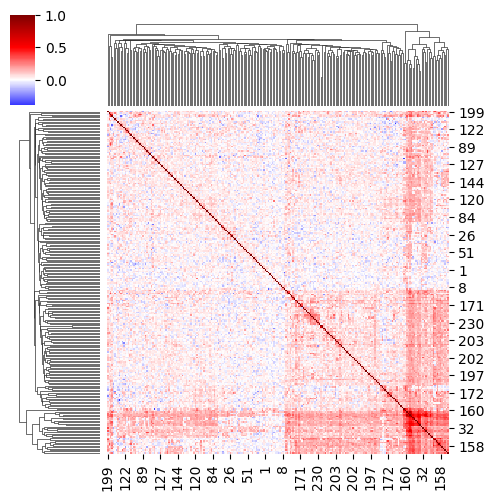

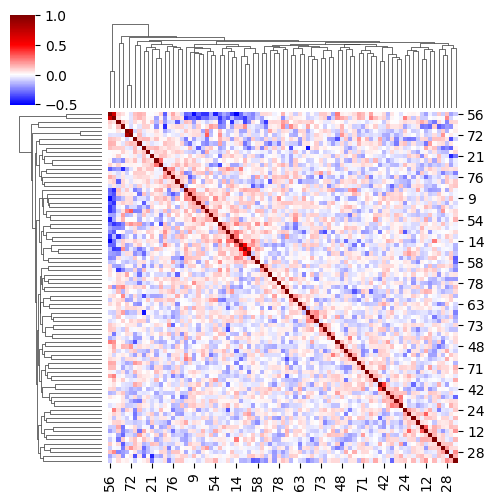

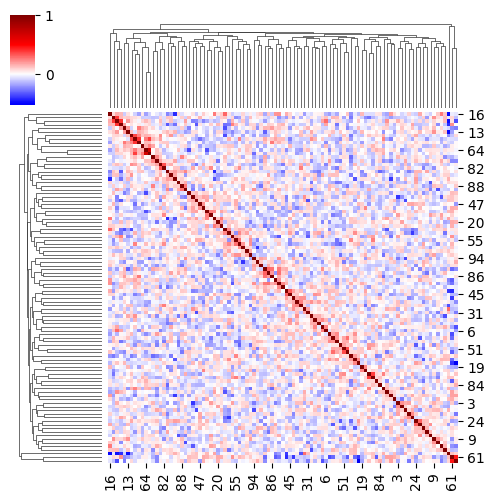

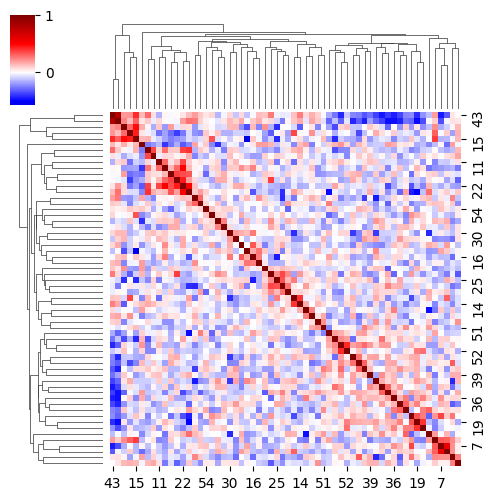

In [31]:
for name, matrix in S.items():
    sns.clustermap(matrix, col_linkage=linkage_dict[name], row_linkage=linkage_dict[name], cmap='seismic', center=0, figsize=(5,5))

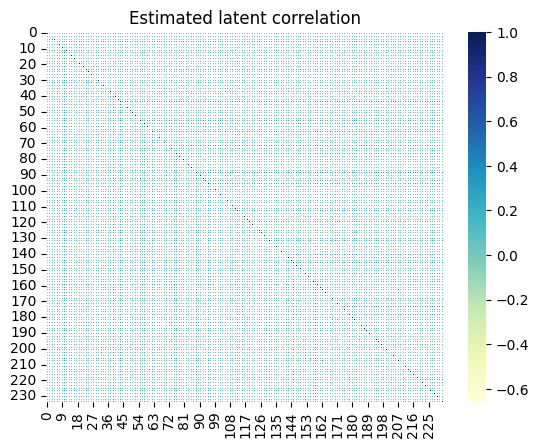

In [96]:
adata = adata_dict["P1_untreated"]

tps = ["tru"] * adata.shape[1]
latent = latentcor(adata.layers["sqrt_counts"].A, tps=tps, method='approx', use_nearPD=False, nu=0, showplot=True)

In [97]:
from statsmodels.stats.correlation_tools import corr_nearest
latent_nearest = corr_nearest(latent["R"], )

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


<Axes: >

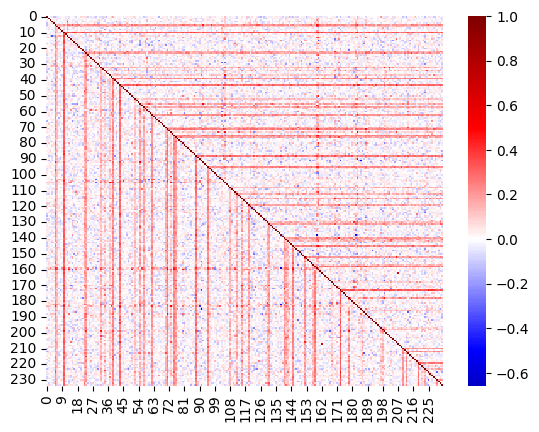

In [101]:
sns.heatmap(latent["R"], cmap='seismic', center=0)

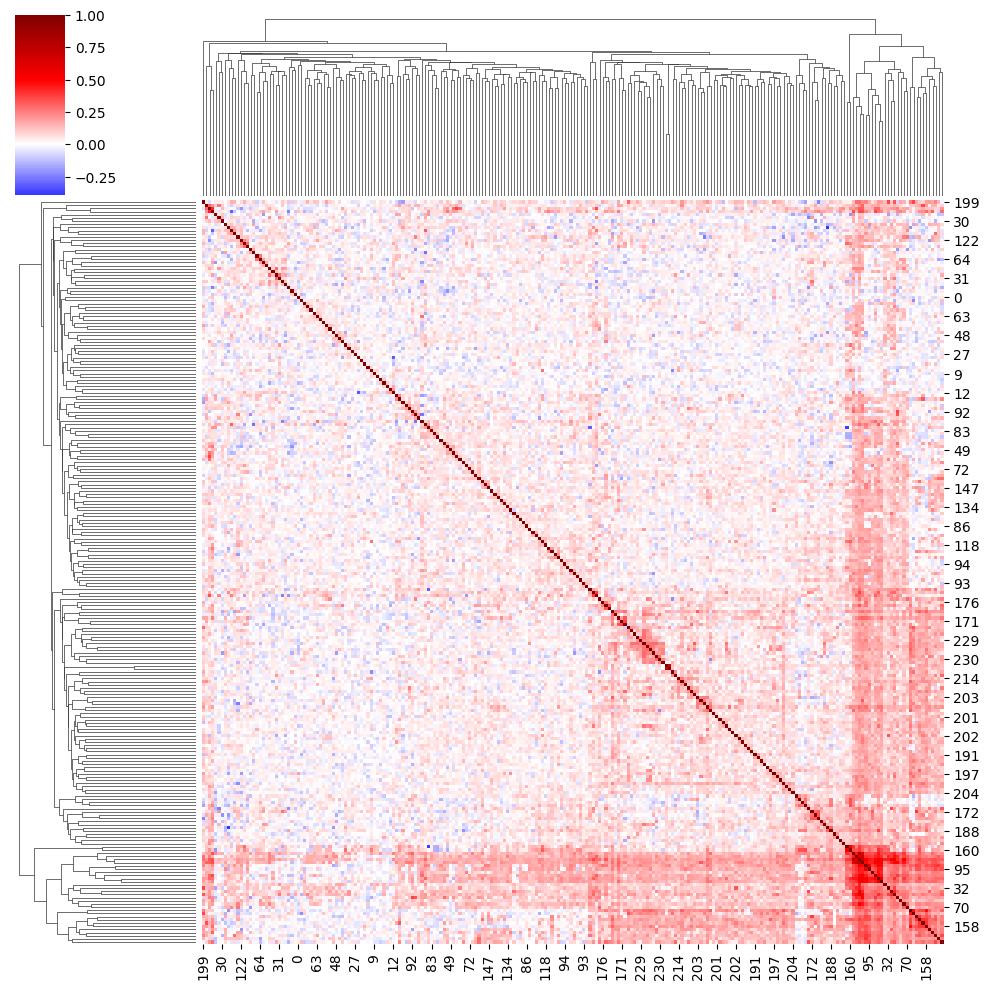

In [103]:
sns.clustermap(latent_nearest, cmap='seismic', center=0)

In [ ]:
def ensure_spd(corr_matrix, epsilon=1e-6):
    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(corr_matrix)
    
    # Adjust the eigenvalues
    eigenvalues[eigenvalues < epsilon] = epsilon
    
    # Reconstruct the SPD matrix
    corr_matrix_spd = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    
    return corr_matrix_spd

In [47]:
ggl_dict = dict()
precision_dict = dict()

for name, matrix in S.items():

    ggl_dict[name] = glasso_problem(S=matrix, 
                                    N=adata_dict[name].shape[0],
                                    reg_params={'lambda1': 0.05}, 
                                    latent=False, 
                                    do_scaling=False)
    
    ggl_dict[name].model_selection(modelselect_params={'lambda1_range': np.logspace(0, -6, 100)}, 
                                   method="eBIC",
                                   gamma=0.1)
    
    print(name, ggl_dict[name].reg_params)
    precision_dict[name] = ggl_dict[name].solution.precision_
    np.save(f"../data/precision_matrices/AP/{name}_mrna_gc05_lc.npy", precision_dict[name])
    np.save(f"../data/model_selec_dicts/AP/{name}_mrna_gc05_lc.npy", ggl_dict[name].__dict__)

ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated 

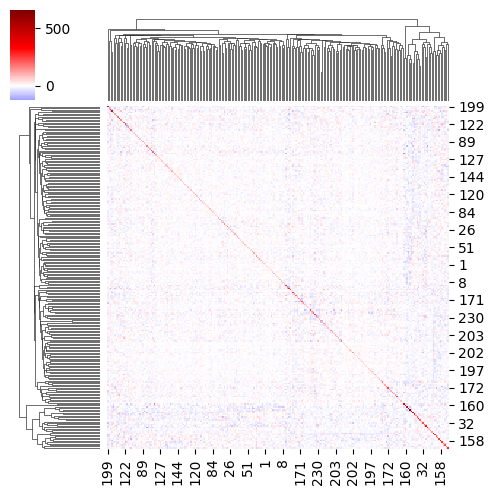

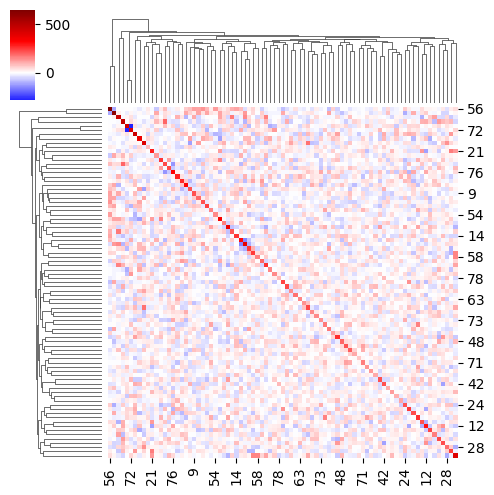

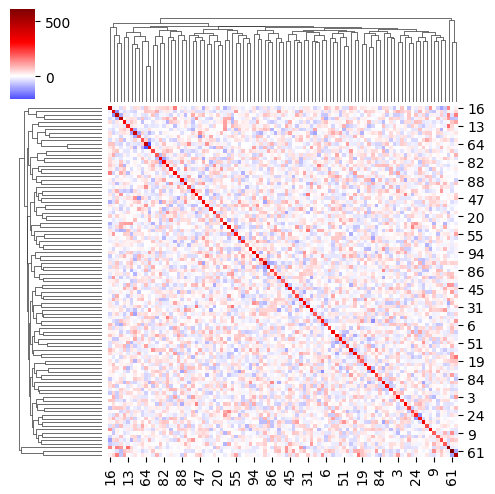

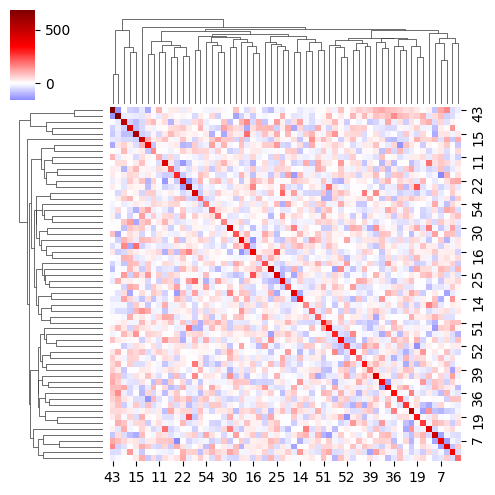

In [48]:
for name, matrix in precision_dict.items():
    sns.clustermap(matrix, col_linkage=linkage_dict[name], row_linkage=linkage_dict[name], cmap='seismic', center=0, figsize=(5,5))

In [50]:
model_selec_dicts = {name: ggl_dict[name].__dict__ for name in ggl_dict.keys()}

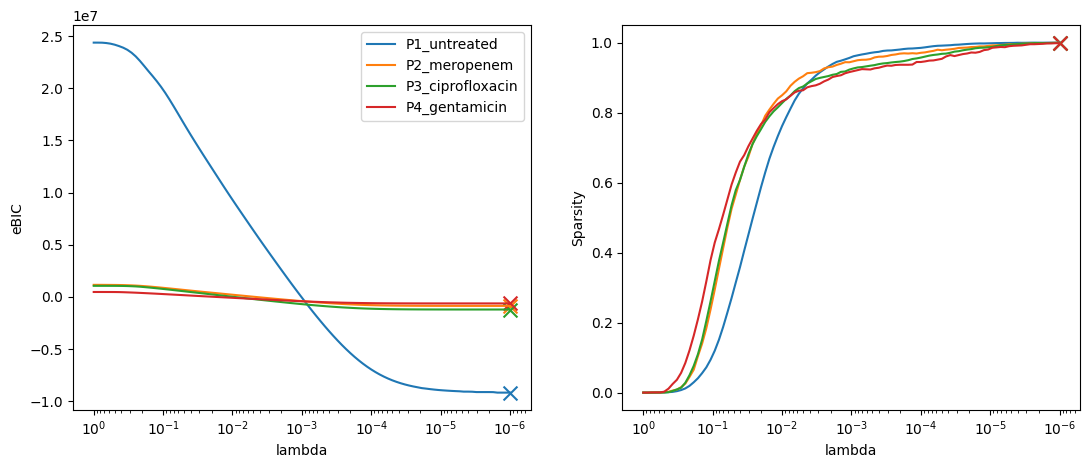

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

for strain in model_selec_dicts.items():
    axs[0].plot(strain[1]["modelselect_params"]["lambda1_range"], strain[1]["modelselect_stats"]["BIC"][0.1], label=strain[0])
    axs[1].plot(strain[1]["modelselect_params"]["lambda1_range"], strain[1]["modelselect_stats"]["SP"], label=strain[0])

    axs[0].scatter(x=strain[1]["modelselect_params"]["lambda1_range"][np.where(strain[1]["modelselect_params"]["lambda1_range"] == strain[1]["reg_params"]["lambda1"])], 
                   y=strain[1]["modelselect_stats"]["BIC"][0.1][np.where(strain[1]["modelselect_params"]["lambda1_range"] == strain[1]["reg_params"]["lambda1"])], 
                   marker='x', s=100)
    
    axs[1].scatter(x=strain[1]["modelselect_params"]["lambda1_range"][np.where(strain[1]["modelselect_params"]["lambda1_range"] == strain[1]["reg_params"]["lambda1"])],
                   y=strain[1]["modelselect_stats"]["SP"][np.where(strain[1]["modelselect_params"]["lambda1_range"] == strain[1]["reg_params"]["lambda1"])], 
                   marker='x', s=100)

axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()

### Pearson

In [61]:
S_pc = dict()
for name, adata in adata_dict.items():
    S_pc[name] = np.corrcoef(adata.layers["sqrt_counts"].A.T, bias=True)
    np.save(f"../data/latent_est/AP/{name}_mrna_gc05_pc.npy", S_pc[name])
    print(name, S_pc[name].shape)

P1_untreated (234, 234)
P2_meropenem (83, 83)
P3_ciprofloxacin (97, 97)
P4_gentamicin (60, 60)


C:\Users\Jan\AppData\Local\Temp\ipykernel_15996\1086237372.py:3: DeprecationWarning: bias and ddof have no effect and are deprecated
  S_pc[name] = np.corrcoef(adata.layers["sqrt_counts"].A.T, bias=True)


In [62]:
linkage_dict_pc = {name: linkage(cor_matrix, method="average", metric="euclidean") for name, cor_matrix in S_pc.items()}

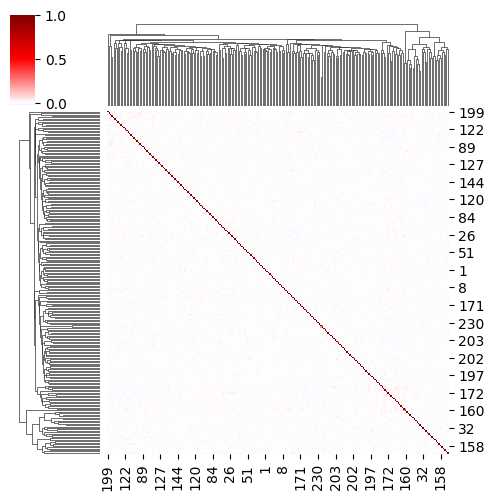

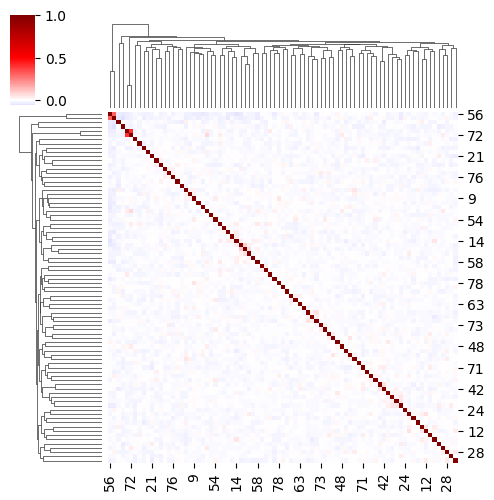

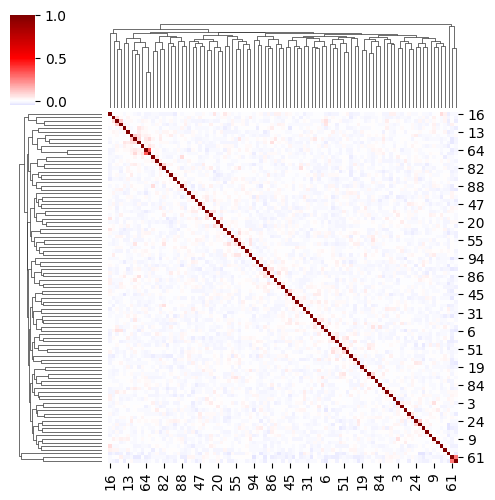

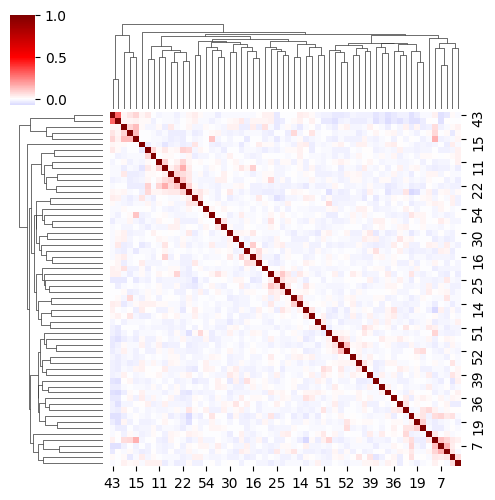

In [63]:
for name, matrix in S_pc.items():
    sns.clustermap(matrix, col_linkage=linkage_dict[name], row_linkage=linkage_dict[name], cmap='seismic', center=0, figsize=(5,5))

In [64]:
ggl_dict_pc = dict()
precision_dict_pc = dict()

for name, matrix in S_pc.items():

    ggl_dict_pc[name] = glasso_problem(S=matrix, 
                                    N=adata_dict[name].shape[0],
                                    reg_params={'lambda1': 0.05}, 
                                    latent=False, 
                                    do_scaling=False)
    
    ggl_dict_pc[name].model_selection(modelselect_params={'lambda1_range': np.logspace(0, -6, 100)}, 
                                   method="eBIC",
                                   gamma=0.1)
    
    print(name, ggl_dict_pc[name].reg_params)
    precision_dict_pc[name] = ggl_dict_pc[name].solution.precision_
    np.save(f"../data/precision_matrices/AP/{name}_mrna_gc05_pc.npy", precision_dict_pc[name])
    np.save(f"../data/model_selec_dicts/AP/{name}_mrna_gc05_pc.npy", ggl_dict_pc[name].__dict__)

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 itera

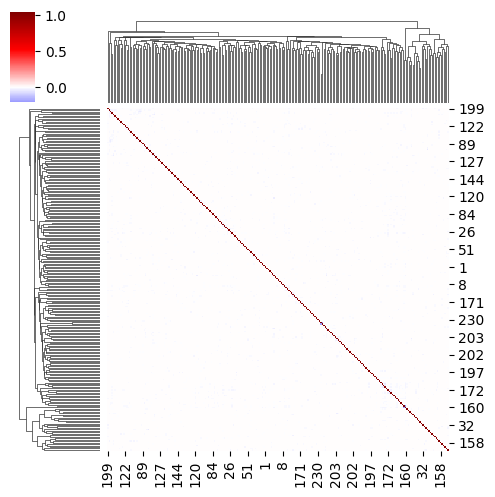

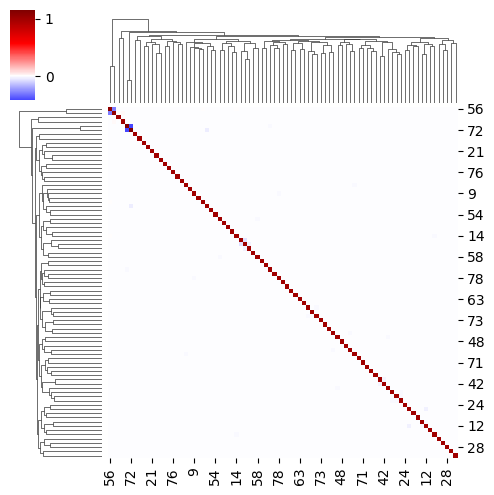

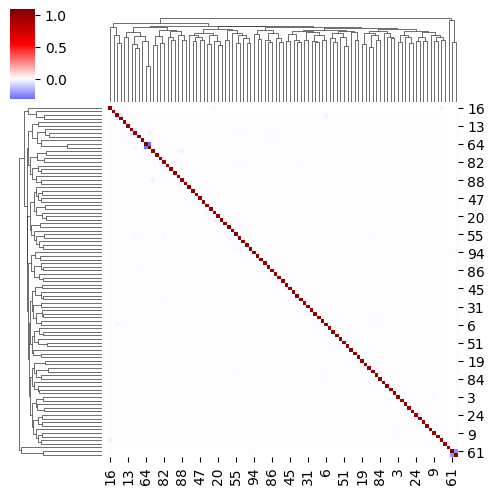

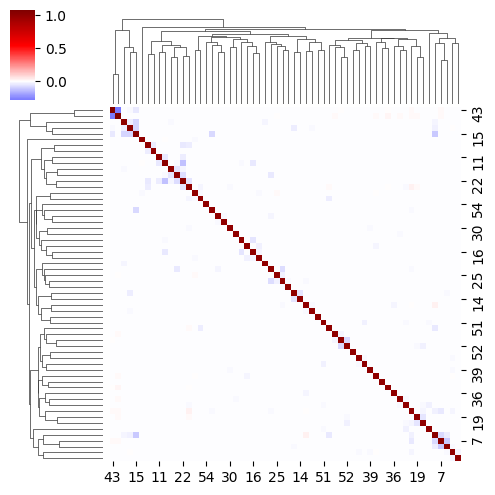

In [65]:
for name, matrix in precision_dict_pc.items():
    sns.clustermap(matrix, col_linkage=linkage_dict[name], row_linkage=linkage_dict[name], cmap='seismic', center=0, figsize=(5,5))

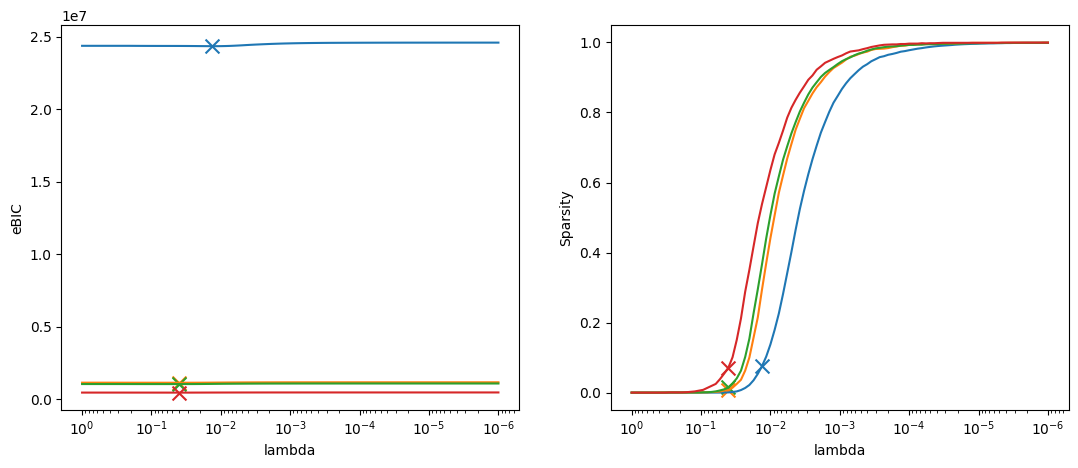

In [69]:
model_selec_dicts_pc = {name: ggl_dict_pc[name].__dict__ for name in ggl_dict_pc.keys()}

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

for strain in model_selec_dicts_pc.items():
    axs[0].plot(strain[1]["modelselect_params"]["lambda1_range"], strain[1]["modelselect_stats"]["BIC"][0.1], label=strain[0])
    axs[1].plot(strain[1]["modelselect_params"]["lambda1_range"], strain[1]["modelselect_stats"]["SP"], label=strain[0])

    axs[0].scatter(x=strain[1]["modelselect_params"]["lambda1_range"][np.where(strain[1]["modelselect_params"]["lambda1_range"] == strain[1]["reg_params"]["lambda1"])], 
                   y=strain[1]["modelselect_stats"]["BIC"][0.1][np.where(strain[1]["modelselect_params"]["lambda1_range"] == strain[1]["reg_params"]["lambda1"])], 
                   marker='x', s=100)
    
    axs[1].scatter(x=strain[1]["modelselect_params"]["lambda1_range"][np.where(strain[1]["modelselect_params"]["lambda1_range"] == strain[1]["reg_params"]["lambda1"])],
                   y=strain[1]["modelselect_stats"]["SP"][np.where(strain[1]["modelselect_params"]["lambda1_range"] == strain[1]["reg_params"]["lambda1"])], 
                   marker='x', s=100)

axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
#axs[0].legend()

axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()

P1_untreated lambda [1.e-06] eBIC [[-9184744.6332592]]
P1_untreated lambda [1.e-06] Sparsity [[1.]]
P2_meropenem lambda [1.e-06] eBIC [[-865915.04656319]]
P2_meropenem lambda [1.e-06] Sparsity [[0.99941228]]
P3_ciprofloxacin lambda [1.e-06] eBIC [[-1213636.09823468]]
P3_ciprofloxacin lambda [1.e-06] Sparsity [[0.99914089]]
P4_gentamicin lambda [1.e-06] eBIC [[-628197.44478471]]
P4_gentamicin lambda [1.e-06] Sparsity [[0.99830508]]

P1_untreated lambda [0.01321941] eBIC [[24362735.68259721]]
P1_untreated lambda [0.01321941] Sparsity [[0.07563919]]
P2_meropenem lambda [0.04037017] eBIC [[1149398.37494115]]
P2_meropenem lambda [0.04037017] Sparsity [[0.00734646]]
P3_ciprofloxacin lambda [0.04037017] eBIC [[1055920.34081997]]
P3_ciprofloxacin lambda [0.04037017] Sparsity [[0.01481959]]
P4_gentamicin lambda [0.04037017] eBIC [[466369.13672135]]
P4_gentamicin lambda [0.04037017] Sparsity [[0.07118644]]


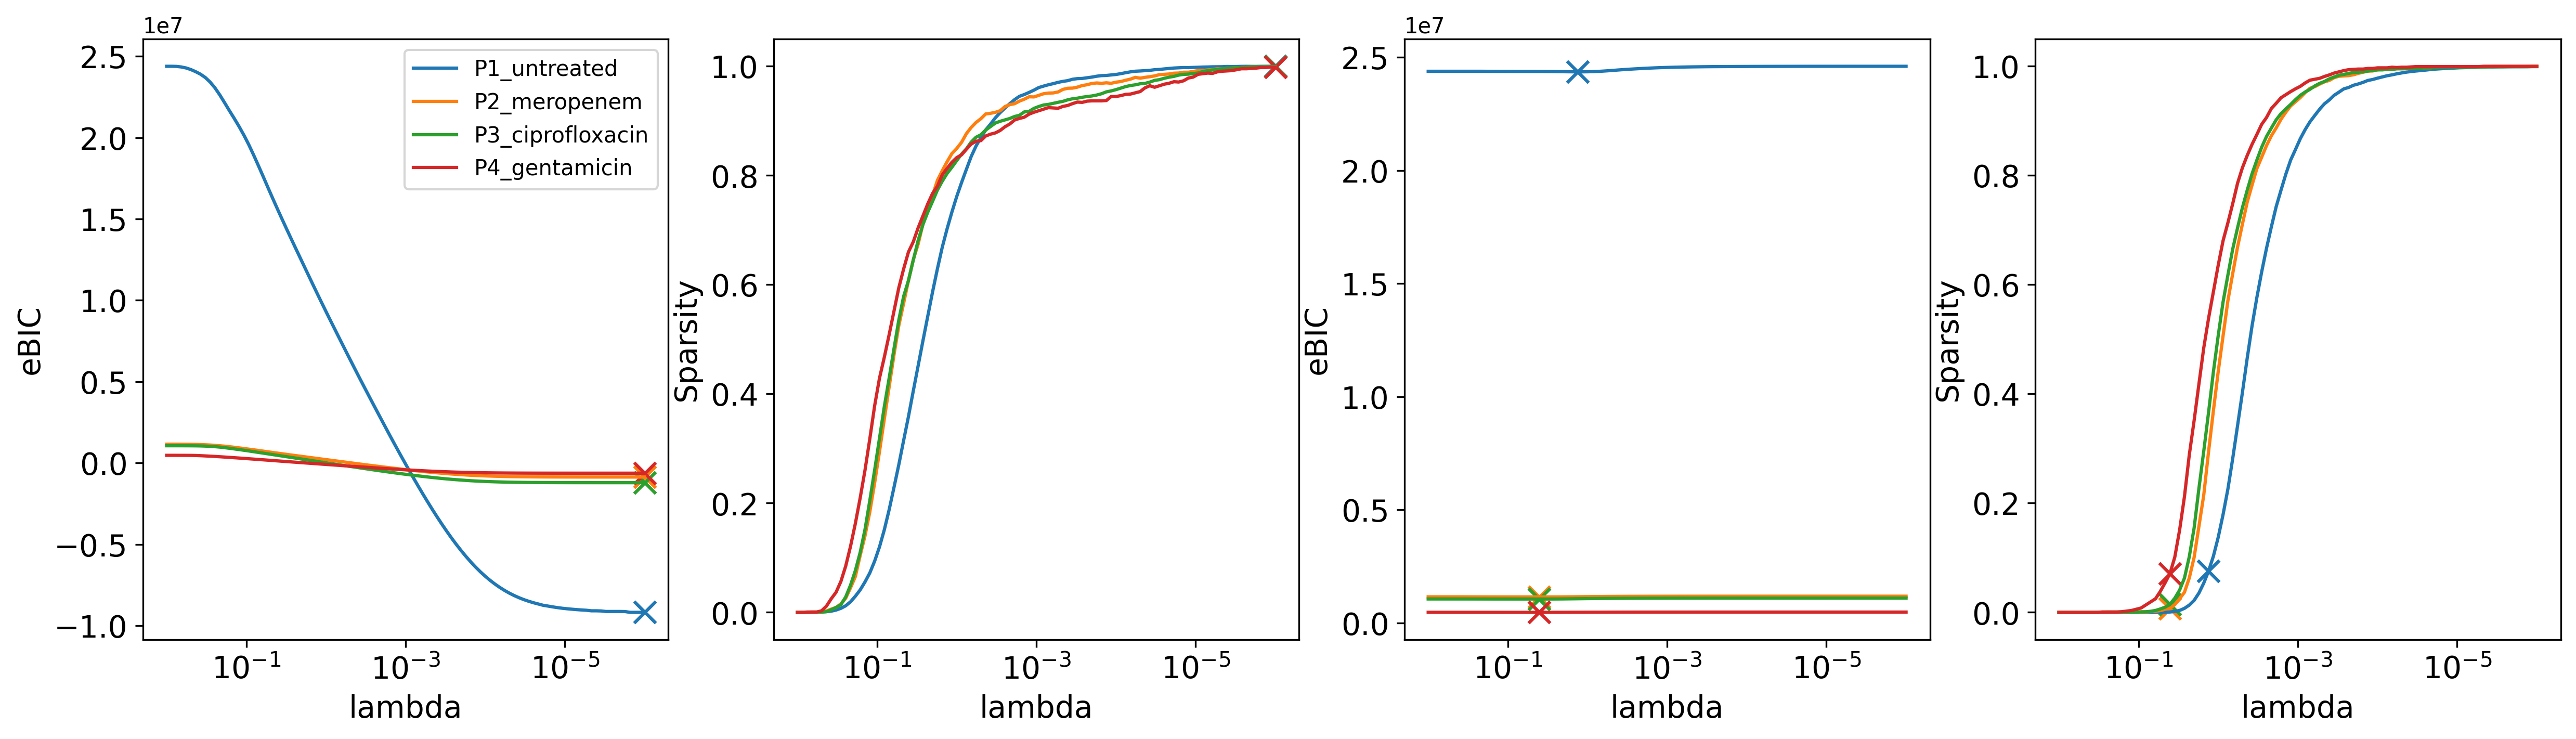

In [93]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=300)

for name, strain in model_selec_dicts.items():
    axs[0].plot(strain["modelselect_params"]["lambda1_range"], strain["modelselect_stats"]["BIC"][0.1], label=name)
    axs[1].plot(strain["modelselect_params"]["lambda1_range"], strain["modelselect_stats"]["SP"], label=name)

    x_1 = strain["modelselect_params"]["lambda1_range"][np.where(strain["modelselect_params"]["lambda1_range"] == strain["reg_params"]["lambda1"])]
    y_1 = strain["modelselect_stats"]["BIC"][0.1][np.where(strain["modelselect_params"]["lambda1_range"] == strain["reg_params"]["lambda1"])]
    print(name, "lambda", x_1, "eBIC", y_1)
    axs[0].scatter(x=x_1, y=y_1, marker='x', s=100)
    
    x_2 = strain["modelselect_params"]["lambda1_range"][np.where(strain["modelselect_params"]["lambda1_range"] == strain["reg_params"]["lambda1"])]
    y_2 = strain["modelselect_stats"]["SP"][np.where(strain["modelselect_params"]["lambda1_range"] == strain["reg_params"]["lambda1"])]
    print(name, "lambda", x_2, "Sparsity", y_2)
    axs[1].scatter(x=x_2,y=y_2, marker='x', s=100)

axs[0].set_xscale("log")
axs[0].set_xlabel("lambda", fontsize=14)
axs[0].set_ylabel("eBIC", fontsize=14)
axs[0].invert_xaxis()
axs[0].legend()

axs[1].set_xscale("log")
axs[1].set_xlabel("lambda", fontsize=14)
axs[1].set_ylabel("Sparsity", fontsize=14)
axs[1].invert_xaxis()
print()

for name, strain in model_selec_dicts_pc.items():
    axs[2].plot(strain["modelselect_params"]["lambda1_range"], strain["modelselect_stats"]["BIC"][0.1], label=name)
    axs[3].plot(strain["modelselect_params"]["lambda1_range"], strain["modelselect_stats"]["SP"], label=name)

    x_1 = strain["modelselect_params"]["lambda1_range"][np.where(strain["modelselect_params"]["lambda1_range"] == strain["reg_params"]["lambda1"])]
    y_1 = strain["modelselect_stats"]["BIC"][0.1][np.where(strain["modelselect_params"]["lambda1_range"] == strain["reg_params"]["lambda1"])]
    print(name, "lambda", x_1, "eBIC", y_1)
    axs[2].scatter(x=x_1, y=y_1, marker='x', s=100)
    
    x_2 = strain["modelselect_params"]["lambda1_range"][np.where(strain["modelselect_params"]["lambda1_range"] == strain["reg_params"]["lambda1"])]
    y_2 = strain["modelselect_stats"]["SP"][np.where(strain["modelselect_params"]["lambda1_range"] == strain["reg_params"]["lambda1"])]
    print(name, "lambda", x_2, "Sparsity", y_2)
    axs[3].scatter(x=x_2,y=y_2, marker='x', s=100)

axs[2].set_xscale("log")
axs[2].set_xlabel("lambda", fontsize=14)
axs[2].set_ylabel("eBIC", fontsize=14)
axs[2].invert_xaxis()
#axs[0].legend()

axs[3].set_xscale("log")
axs[3].set_xlabel("lambda", fontsize=14)
axs[3].set_ylabel("Sparsity", fontsize=14)
axs[3].invert_xaxis()

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)